In [1]:
# Install necessary libraries
!pip install --no-index --find-links /kaggle/input/openvino-lib openvino -q

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
import joblib
import openvino as ov
import librosa
import torch
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load and explore metadata

In [3]:
meta_df = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')

In [4]:
meta_df.head(10)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg
5,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209219,asbfly/XC209219.ogg
6,asbfly,[],['clicks its bill'],42.5275,130.6920,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/267679,asbfly/XC267679.ogg
7,asbfly,[],"['call', 'male', 'song']",44.3602,132.7989,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267680,asbfly/XC267680.ogg
8,asbfly,[],"['call', 'male', 'song']",44.3602,132.7989,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267681,asbfly/XC267681.ogg
9,asbfly,[],['alarm call'],42.5275,130.6920,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/267682,asbfly/XC267682.ogg


In [5]:
meta_df.shape

(24459, 12)

In [6]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


In [7]:
meta_df['secondary_labels'].value_counts().head()

secondary_labels
[]             22567
['houspa']       186
['eucdov']        82
['houcro1']       76
['spodov']        47
Name: count, dtype: int64

In [8]:
meta_df['rating'].value_counts().head()

rating
4.0    7169
5.0    6549
3.0    3177
3.5    2480
4.5    2131
Name: count, dtype: int64

In [9]:
print(len(meta_df['scientific_name'].unique()))

182


In [10]:
meta_df.dtypes

primary_label        object
secondary_labels     object
type                 object
latitude            float64
longitude           float64
scientific_name      object
common_name          object
author               object
license              object
rating              float64
url                  object
filename             object
dtype: object

In [11]:
import seaborn as sns

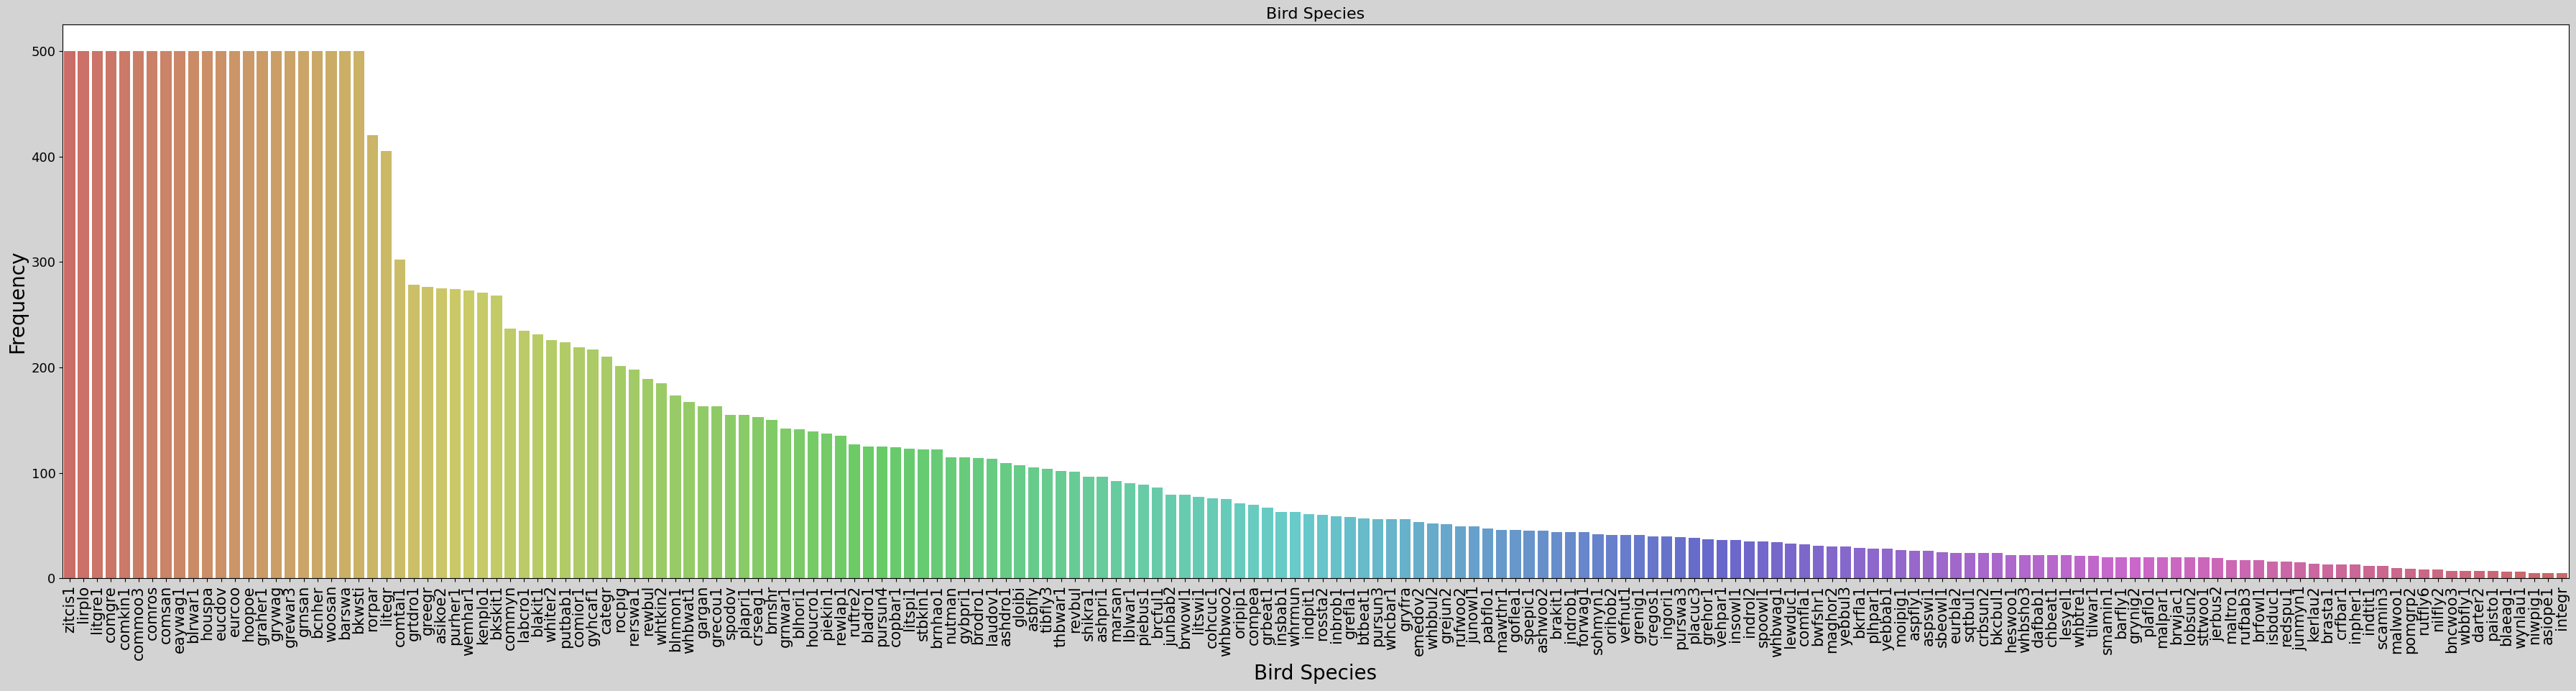

In [12]:
bird_path = '/kaggle/input/birdcall-recognition-data/blue bird.jpg'

xy = (0.5, 0.7)

label_counts = meta_df['primary_label'].value_counts()

label_counts = meta_df['primary_label'].value_counts()
plt.figure(figsize=(45, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="hls")


plt.title("Bird Species", fontsize=16)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Bird Species", fontsize=20)
plt.gcf().set_facecolor('lightgrey')  # Set background color of the entire figure

plt.show()

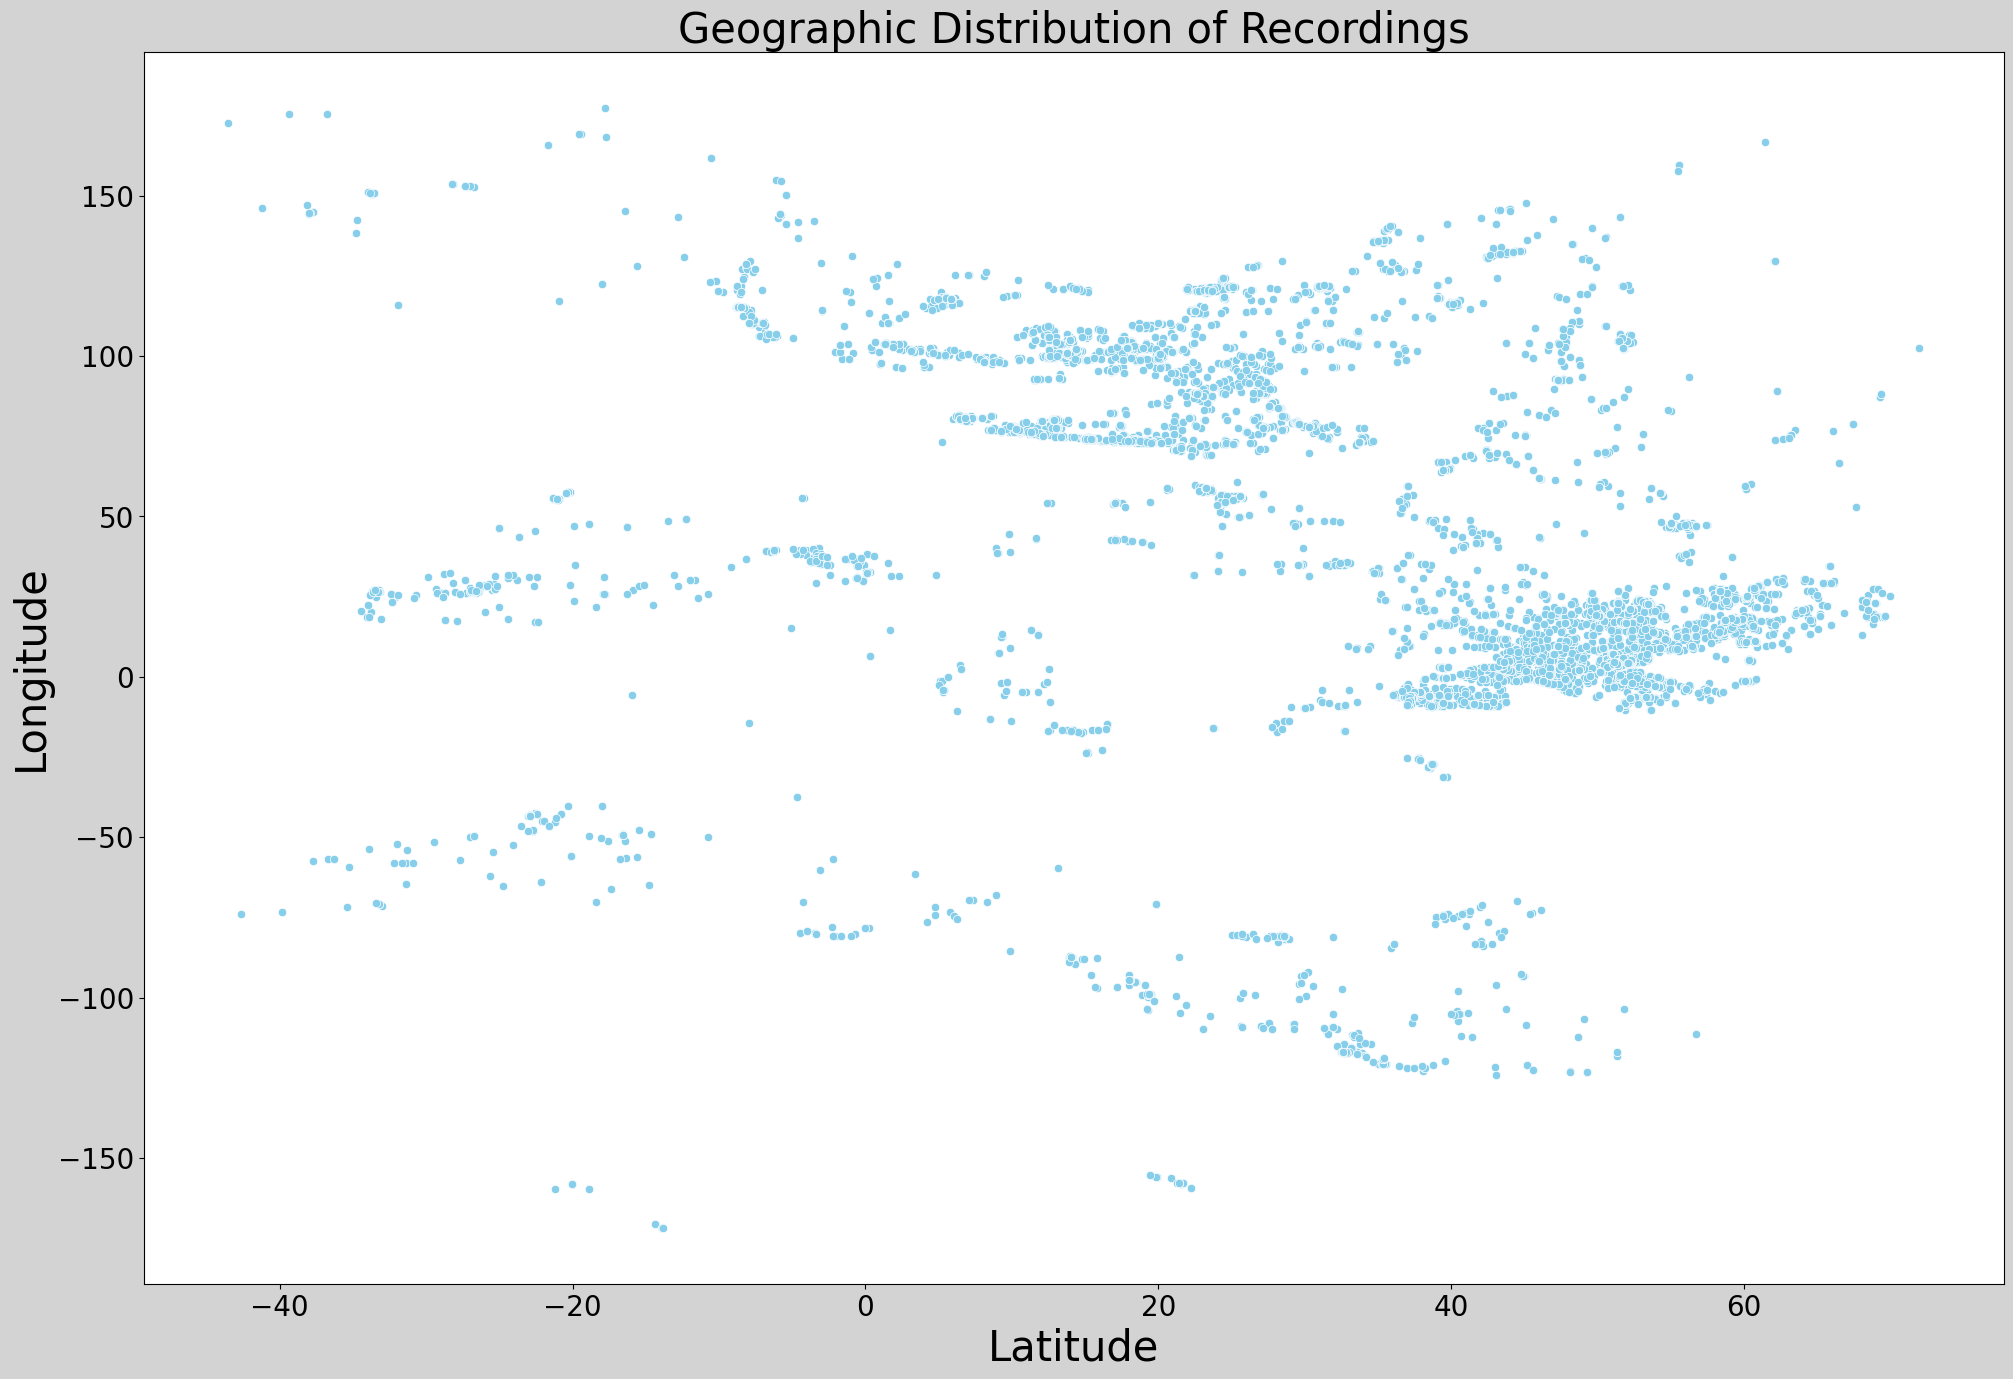

In [13]:
xy = (0.5, 0.7)

plt.figure(figsize=(24, 16))
sns.scatterplot(x='latitude', y='longitude', data=meta_df, color='skyblue')
plt.gca()

plt.title("Geographic Distribution of Recordings", fontsize=30)
plt.xlabel("Latitude", fontsize=30)
plt.ylabel("Longitude", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().set_facecolor('lightgrey')  # Set background color of the entire figure

plt.show()

In [14]:
# Feature extraction and preprocessing
SHAPE = [48, 1, 128, 320 * 2]

def mel(arr, sr=32_000):
    arr = arr * 1024
    S = librosa.feature.melspectrogram(y=arr, sr=sr,
                                       n_fft=1024, hop_length=500, n_mels=128, 
                                       fmin=40, fmax=15000, power=2.0)
    return S

def mel_preproc(x):
    x = librosa.power_to_db(x, ref=1, top_db=100.0)
    x = x.astype('float32')
    return x

In [15]:
# Convert PyTorch model to OpenVINO
def torch_to_ov(model, input_shape=[48, 1, 128, 0], name='model'):
    core = ov.Core()
    ov_model = ov.convert_model(model)
    compiled_model = core.compile_model(ov_model)
    return compiled_model

# Load pre-trained models
names = [
    'effnet_seg20_80low.ckpt',
    'effnet_seg60_80low.ckpt',
    'effnet_seg60_fold0.ckpt',
    'regnety_seg60_fold0.ckpt',
    'regnety_seg30_fold0.ckpt',
    'regnety_seg30_80low.ckpt',
]

models = []
for i, name in enumerate(names):
    state_dict = torch.load(f'/kaggle/input/birdclef24-final/{name}', map_location=torch.device('cpu'))
    model_name = 'efficientnet_b0' if 'regnety' not in name else 'regnety_008.pycls_in1k'
    
    model = timm.create_model(model_name, pretrained=None, num_classes=182, in_chans=SHAPE[1])
    new_state_dict = {key[6:]: val for key, val in state_dict['state_dict'].items() if key.startswith('model.')}
    model.load_state_dict(new_state_dict)
    model.eval()
    model = torch_to_ov(model, input_shape=SHAPE)
    models.append(model)

print(f'{len(models)} models are ready')

/tmp/ipykernel_17/706823020.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'/kaggle/input/birdclef24-final/{name}', map_location=torch.device(

6 models are ready


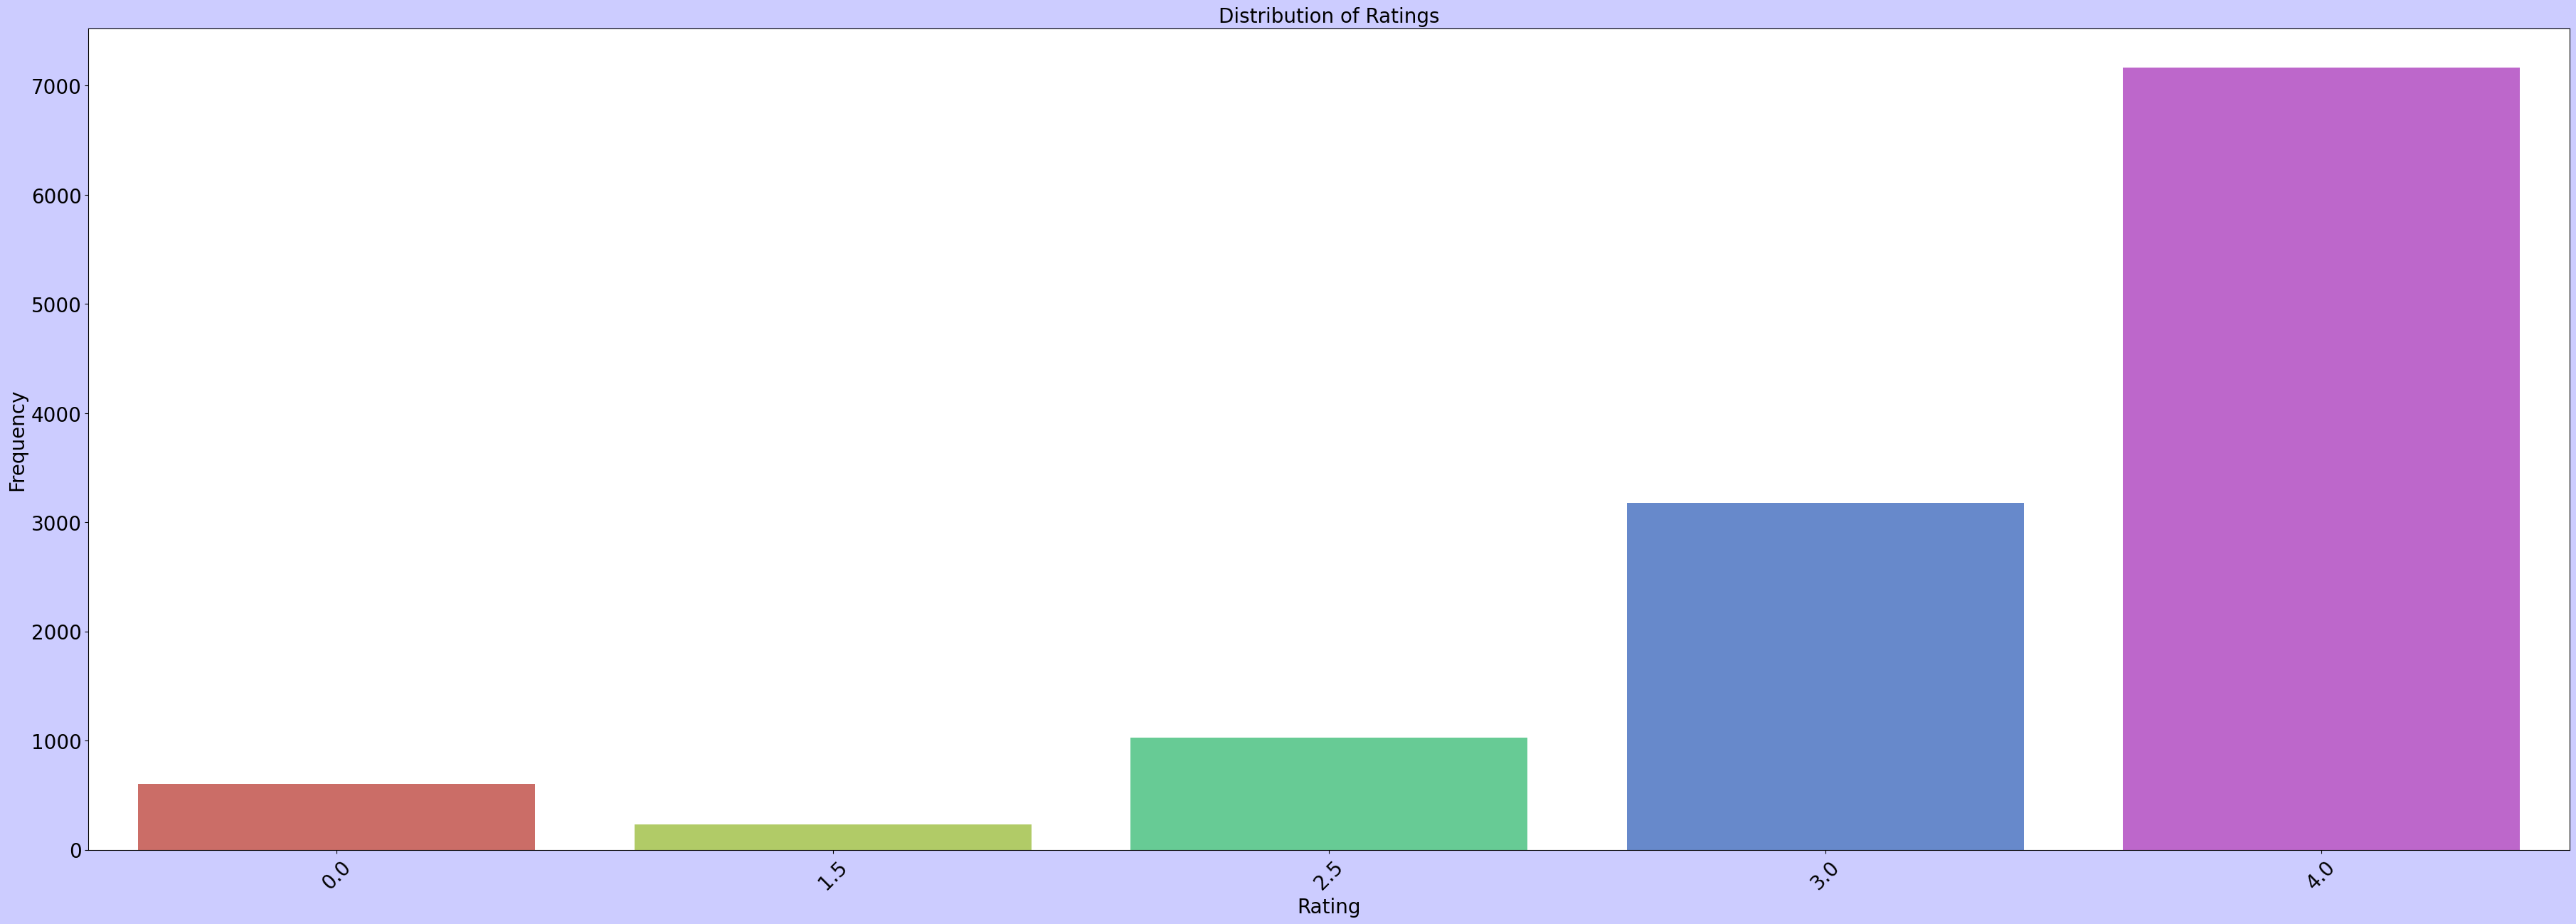

In [16]:
import random
num_ratings = random.randint(2, 5)  
selected_ratings = random.sample(list(meta_df['rating'].unique()), k=num_ratings)
df_selected_ratings = meta_df[meta_df['rating'].isin(selected_ratings)]
palette = sns.color_palette("hls", n_colors=num_ratings)

xy = (0.5, 0.7)

plt.figure(figsize=(45, 15))
sns.countplot(x='rating', data=df_selected_ratings, palette=palette)

plt.title("Distribution of Ratings", fontsize=20)
plt.xlabel("Rating", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().set_facecolor('#CCCCFF')  # Set background color of the entire figure

plt.show()

In [17]:
# Load test data and perform inference
test_audio_dir = '/kaggle/input/birdclef-2024/test_soundscapes/'
test_paths = [test_audio_dir + f for f in sorted(os.listdir(test_audio_dir))]
if len(test_paths) == 1:
    test_audio_dir = '/kaggle/input/birdclef-2024/unlabeled_soundscapes/'
    test_paths = [test_audio_dir + f for f in sorted(os.listdir(test_audio_dir))][:3]
test_df = pd.DataFrame(test_paths, columns=['filepath'])
test_df['filename'] = test_df.filepath.map(lambda x: x.split('/')[-1].replace('.ogg', ''))

def process(idx):
    row = test_df.iloc[idx]
    audiopath = row['filepath']
    audio, sr = librosa.load(audiopath, sr=None)
    chunk_size = sr * 5
    chunks = audio.reshape(-1, chunk_size)
    chunks_mel = mel(chunks, sr=sr)[:, :, :320].astype(np.float32)
    return row['filename'], chunks_mel

indexes = test_df.index
output = joblib.Parallel(n_jobs=-1, backend="loky")(joblib.delayed(process)(idx) for idx in indexes)
mels_dict = dict(output)

In [18]:
print(mels_dict)

{'1000170626': array([[[  78.82687  ,  291.79642  ,  994.96686  , ...,  884.93774  ,
           90.746346 ,  683.96246  ],
        [  31.225357 ,   32.70745  ,  542.9008   , ...,   94.53618  ,
           21.80438  ,  736.6338   ],
        [   4.609026 ,  108.11294  ,  110.830505 , ...,    4.0084496,
           61.006638 ,   53.740437 ],
        ...,
        [  26.804111 ,   99.72696  ,   68.0078   , ...,   98.49868  ,
           92.53726  ,   45.238693 ],
        [  55.53028  ,   86.79964  ,  104.78997  , ...,  100.730606 ,
          111.432846 ,   77.49408  ],
        [  40.381767 ,  155.9031   ,   99.495316 , ...,  109.42421  ,
          111.217865 ,  203.49211  ]],

       [[  65.97223  ,   23.075161 ,  585.52344  , ...,   42.747536 ,
          149.28146  ,  494.22418  ],
        [  82.58171  ,   89.44252  , 1326.3682   , ...,   24.086433 ,
           60.078175 ,  327.28226  ],
        [  68.342896 ,   10.297348 , 1204.9282   , ...,  145.3957   ,
           94.035866 ,  339.74368  ]

In [19]:
# Perform predictions
ids = []
preds = [np.empty(shape=(0, 182), dtype='float32') for _ in range(len(models))]

for filename in test_df.filename.tolist():
    chunks = mels_dict[filename]
    chunks = chunks[:, np.newaxis, :, :]
    chunks_1 = np.concatenate([chunks[:1], chunks[:-1]], axis=0)
    chunks_2 = np.concatenate([chunks[1:], chunks[-1:]], axis=0)
    chunks = np.concatenate([chunks_1, chunks, chunks_2], axis=-1)
    chunks = chunks[..., 160:-160]
    chunks = mel_preproc(chunks)
    
    for m_idx in range(len(models)):
        rec_preds = models[m_idx](torch.from_numpy(chunks))[0]
        preds[m_idx] = np.concatenate([preds[m_idx], rec_preds], axis=0)

    rec_ids = [f'{filename}_{(frame_id + 1) * 5}' for frame_id in range(rec_preds.shape[0])]
    ids += rec_ids

preds = F.sigmoid(torch.Tensor(np.array(preds))).numpy()

In [20]:
# Aggregation and post-processing
s0 = preds.shape[0]
preds = preds.reshape(s0, -1, 48, 182)
smooth_preds = preds.copy()
for i in range(48):
    smooth_preds[:, :, i] = preds[:, :, max(0, i - 2):i + 3].mean(axis=-2)
preds = smooth_preds.reshape(s0, -1, 182)

preds = preds.mean(axis=0, keepdims=True)
preds = preds.squeeze()

# Visualization

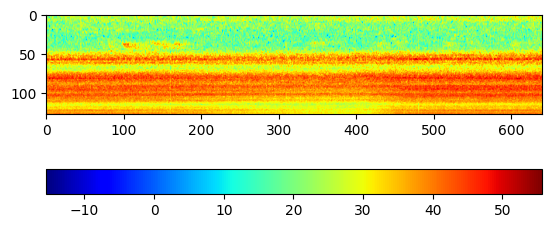

In [21]:
# Visualization
ims = plt.imshow(chunks[24][0], cmap='jet')
plt.colorbar(ims, orientation='horizontal')
plt.show()

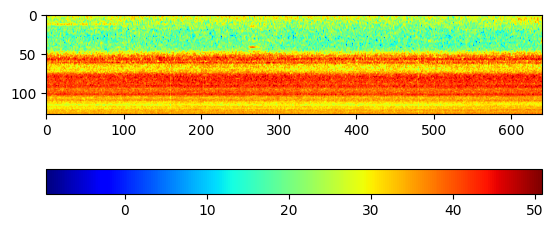

In [22]:
ims = plt.imshow(chunks[1][0], cmap='jet')
plt.colorbar(ims, orientation='horizontal')
plt.show()

In [23]:
data = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
LABELS = sorted(list(data['primary_label'].unique()))

pred_df = pd.DataFrame(ids, columns=['row_id'])
pred_df.loc[:, LABELS] = preds

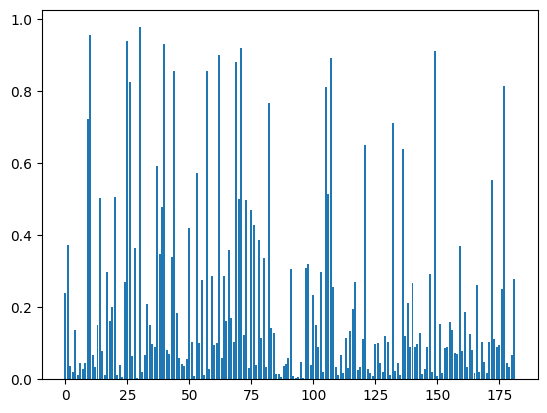

In [24]:
plt.bar(range(182), pred_df.iloc[24][LABELS])
plt.show()

In [25]:
pred_df.to_csv('submission.csv', index=False)
pred_df.head(9)

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.211159,0.370415,0.034738,0.023202,0.125270,0.012154,0.040810,0.022051,0.054049,...,0.531776,0.093885,0.095396,0.111565,0.287564,0.800359,0.037497,0.037421,0.071256,0.256902
1,1000170626_10,0.210072,0.384895,0.031817,0.022404,0.129922,0.011442,0.041278,0.022258,0.056046,...,0.541001,0.096715,0.088430,0.108468,0.307907,0.792443,0.038633,0.037775,0.073873,0.252936
2,1000170626_15,0.216251,0.381160,0.030532,0.022538,0.133169,0.011660,0.042308,0.022923,0.058211,...,0.549404,0.105671,0.088850,0.104548,0.312550,0.787815,0.042056,0.038025,0.080441,0.254204
3,1000170626_20,0.213174,0.361605,0.032002,0.022882,0.141252,0.012151,0.041464,0.023652,0.052004,...,0.551462,0.107331,0.091811,0.098789,0.300865,0.780003,0.044241,0.037821,0.080130,0.259736
4,1000170626_25,0.211845,0.363415,0.032497,0.025413,0.149910,0.012583,0.041990,0.024688,0.052028,...,0.551698,0.107771,0.101747,0.122624,0.299362,0.771989,0.044238,0.042358,0.089502,0.267690
5,1000170626_30,0.212966,0.391021,0.028641,0.025656,0.153235,0.010978,0.043464,0.024306,0.054960,...,0.555527,0.112351,0.100283,0.139210,0.315990,0.765831,0.042713,0.045816,0.101378,0.265625
6,1000170626_35,0.207925,0.392484,0.031004,0.026819,0.161296,0.010831,0.045796,0.023752,0.051353,...,0.546653,0.113994,0.101706,0.151460,0.300016,0.762721,0.040329,0.048953,0.107127,0.267344
7,1000170626_40,0.198902,0.401613,0.033732,0.027508,0.169616,0.010602,0.046078,0.023551,0.048444,...,0.536300,0.107167,0.101435,0.160565,0.294771,0.759674,0.035977,0.052192,0.106217,0.267660
8,1000170626_45,0.206209,0.374315,0.035821,0.029310,0.174653,0.011705,0.047902,0.024428,0.048437,...,0.544190,0.115659,0.107867,0.156778,0.290818,0.770338,0.036737,0.050453,0.103569,0.276945
